In [395]:
# Import necessary libraries
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Function to segment the image
def segment_image(image):
    if image is None:
        raise ValueError("Image is None. Ensure the image path is correct.")
    
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
    
    segments = [image[y:y+h, x:x+w] for x, y, w, h in [cv2.boundingRect(c) for c in contours]]

    return segments

# Function to preprocess the image segment
def preprocess_image(segment):
    resized = cv2.resize(segment, (100, 100))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    return gray

# Function to preprocess the templates from multiple directories
def preprocess_templates(template_dirs):
    preprocessed_templates = {}
    for template_dir in template_dirs:
        for alphabet_file in os.listdir(template_dir):
            template_path = os.path.join(template_dir, alphabet_file)
            template = cv2.imread(template_path)
            if template is not None:
                segments = segment_image(template)
                if segments:
                    template_preprocessed = [preprocess_image(segment) for segment in segments]
                    preprocessed_templates[alphabet_file] = template_preprocessed
    return preprocessed_templates

# Function to compare images using cross-correlation
def compare_images(input_processed, template):
    input_height, input_width = input_processed.shape
    template_height, template_width = template.shape
    template_mean = np.mean(template)
    max_correlation_value = -float('inf')

    for y in range(input_height - template_height + 1):
        for x in range(input_width - template_width + 1):
            roi = input_processed[y:y+template_height, x:x+template_width]
            roi_mean = np.mean(roi)
            denominator = np.sqrt(np.sum((roi - roi_mean)**2) * np.sum((template - template_mean)**2))
            if denominator > 0:
                correlation_value = np.sum((roi - roi_mean) * (template - template_mean)) / denominator
                if correlation_value > max_correlation_value:
                    max_correlation_value = correlation_value

    return max_correlation_value

# Function to recognize alphabets from the input image
def recognize_alphabets(input_image, preprocessed_templates):
    segments = segment_image(input_image)
    recognized_alphabets = []

    for segment in segments:
        input_processed = preprocess_image(segment)
        max_match_val = -1
        recognized_alphabet = None

        for alphabet_file, templates in preprocessed_templates.items():
            for template in templates:
                match_val = compare_images(input_processed, template)
                if match_val > max_match_val:
                    max_match_val = match_val
                    recognized_alphabet = os.path.splitext(alphabet_file)[0]  # Extract the alphabet from the filename

        recognized_alphabets.append((recognized_alphabet, max_match_val))

    return recognized_alphabets

# Directories containing template alphabet images
template_dirs = ['datasets/templates/small', 'datasets/templates/capital']
# template_dirs = ['datasets/templates/capital']

# Preprocess the template images
preprocessed_templates = preprocess_templates(template_dirs)




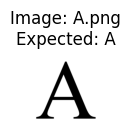

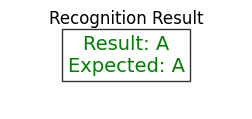

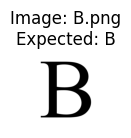

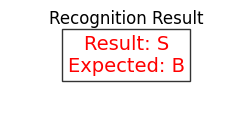

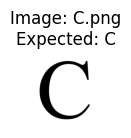

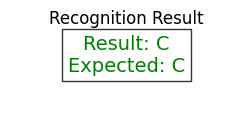

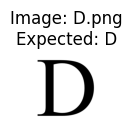

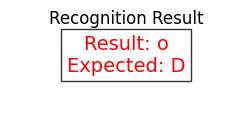

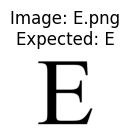

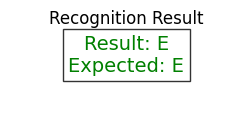

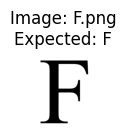

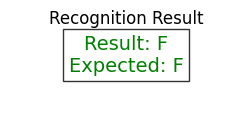

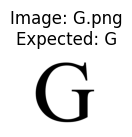

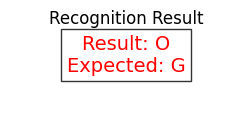

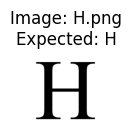

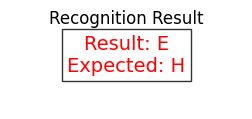

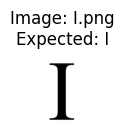

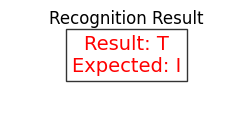

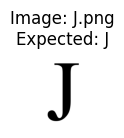

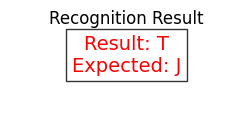

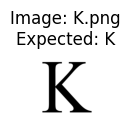

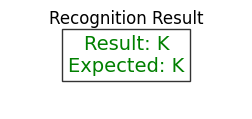

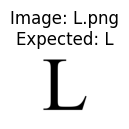

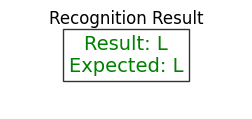

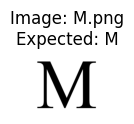

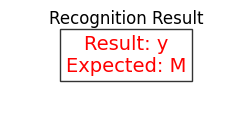

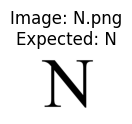

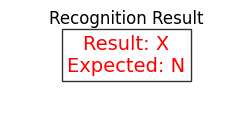

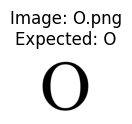

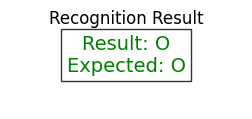

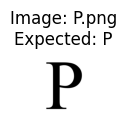

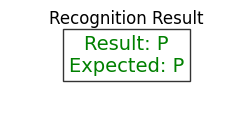

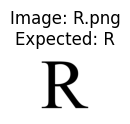

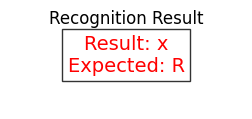

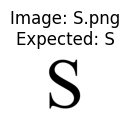

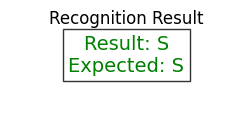

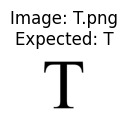

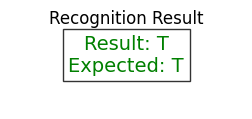

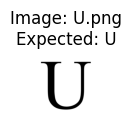

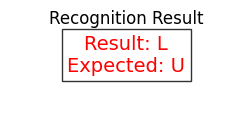

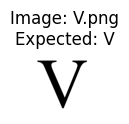

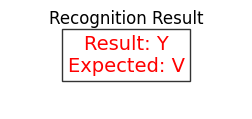

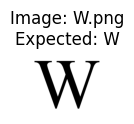

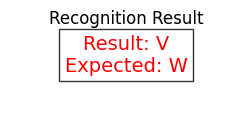

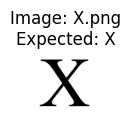

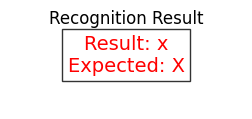

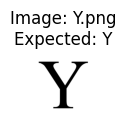

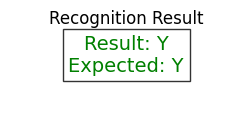

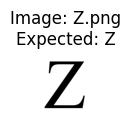

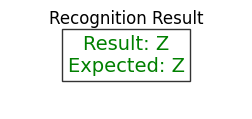

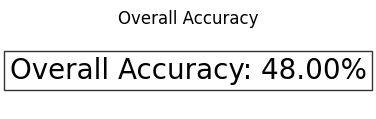

In [413]:
# Function to recognize alphabets from the input image
def recognize_alphabets(input_image, preprocessed_templates):
    segments = segment_image(input_image)
    recognized_alphabets = []
    contours_images = []  # List to store the contour images for visualization

    for segment in segments:
        input_processed = preprocess_image(segment)
        contours_images.append(segment)  # Add the segment image to the contours list
        max_match_val = -1
        recognized_alphabet = None

        for alphabet_file, templates in preprocessed_templates.items():
            for template in templates:
                match_val = compare_images(input_processed, template)
                if match_val > max_match_val:
                    max_match_val = match_val
                    recognized_alphabet = os.path.splitext(alphabet_file)[0]  # Extract the alphabet from the filename

        recognized_alphabets.append((recognized_alphabet, max_match_val))

    return recognized_alphabets, contours_images  # Return both recognized alphabets and the contour images

# Debugging - Show the test image and combined results
# Debugging - Show the test image and combined results
def show_debug_images(test_image, recognized_alphabets, expected_alphabet, image_name, contours_images):
    # Display the test image with title
    plt.figure(figsize=(2, 1))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Image: {image_name}\nExpected: {expected_alphabet}")
    plt.axis('off')
    plt.show()

    # Display each contour and its recognized alphabet on a separate row
    # num_contours = len(contours_images)
    # plt.figure(figsize=(3, 5 * num_contours))
    
    # for i, (contour_image, (recognized_alphabet, _)) in enumerate(zip(contours_images, recognized_alphabets)):
    #     plt.subplot(num_contours, 2, 2*i + 1)
    #     plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
    #     plt.title(f"Contour {i + 1}")
    #     plt.axis('off')

    #     plt.subplot(num_contours, 2, 2*i + 2)
    #     plt.text(0.5, 0.5, f"Recognized: {recognized_alphabet}",
    #              fontsize=14, ha='center', va='center', color='blue',
    #              bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    #     plt.axis('off')
    
    # plt.tight_layout()
    # plt.show()

    # Combine recognized segments into a single string
    combined_result = ''.join([recognized_alphabet for recognized_alphabet, match_val in recognized_alphabets if recognized_alphabet is not None])

    # Display combined result as a separate image
    plt.figure(figsize=(3, 1))
    plt.text(0.5, 0.7, f"Result: {combined_result}\nExpected: {expected_alphabet}",
             fontsize=14, ha='center', va='center', color='green' if combined_result.replace(' ', '') == expected_alphabet.replace(' ', '') else 'red',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    plt.title("Recognition Result")
    plt.axis('off')
    plt.show()

def test_accuracy(test_dir, preprocessed_templates):
    # Initialize counters for accuracy calculation
    total_images = 0
    correct_images = 0

    for test_file in os.listdir(test_dir):
        test_image_path = os.path.join(test_dir, test_file)
        test_image = cv2.imread(test_image_path)

        if test_image is not None:
            # Recognize alphabets and get the contours images
            recognized_alphabets, contours_images = recognize_alphabets(test_image, preprocessed_templates)
            expected_alphabet = os.path.splitext(test_file)[0].split('-')[0].strip()

            # Check if the combined result matches the expected result
            combined_result = ''.join([recognized_alphabet for recognized_alphabet, match_val in recognized_alphabets if recognized_alphabet is not None])
            
            # Compare ignoring spaces
            if combined_result.replace(' ', '') == expected_alphabet.replace(' ', ''):
                correct_images += 1

            total_images += 1

            # Show debugging images for each contour
            show_debug_images(test_image, recognized_alphabets, expected_alphabet, test_file, contours_images)

    # Calculate overall accuracy
    overall_accuracy = (correct_images / total_images) * 100 if total_images > 0 else 0

    # Display the overall accuracy
    plt.figure(figsize=(3, 1))
    plt.text(0.5, 0.5, f"Overall Accuracy: {overall_accuracy:.2f}%",
            fontsize=20, ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    plt.title("Overall Accuracy")
    plt.axis('off')
    plt.show()


# Directory containing handwritten test images
# test_dir = 'datasets/complex-h'
# test_dir = 'datasets/hand-written'
test_dir = 'datasets/other-font'
test_accuracy(test_dir, preprocessed_templates)
